Δημιουργία ενός _real system_ για προσομοίωση του πραγματικού συστήματος. Στους τελικούς υπολογισμούς των X και S από το _real system_ προσθέτω noise ή χρησιμοποιώ διαφορετικό 'real' model.

Maximum biomass concentration: 22.31 g/l at time 4.50 hours


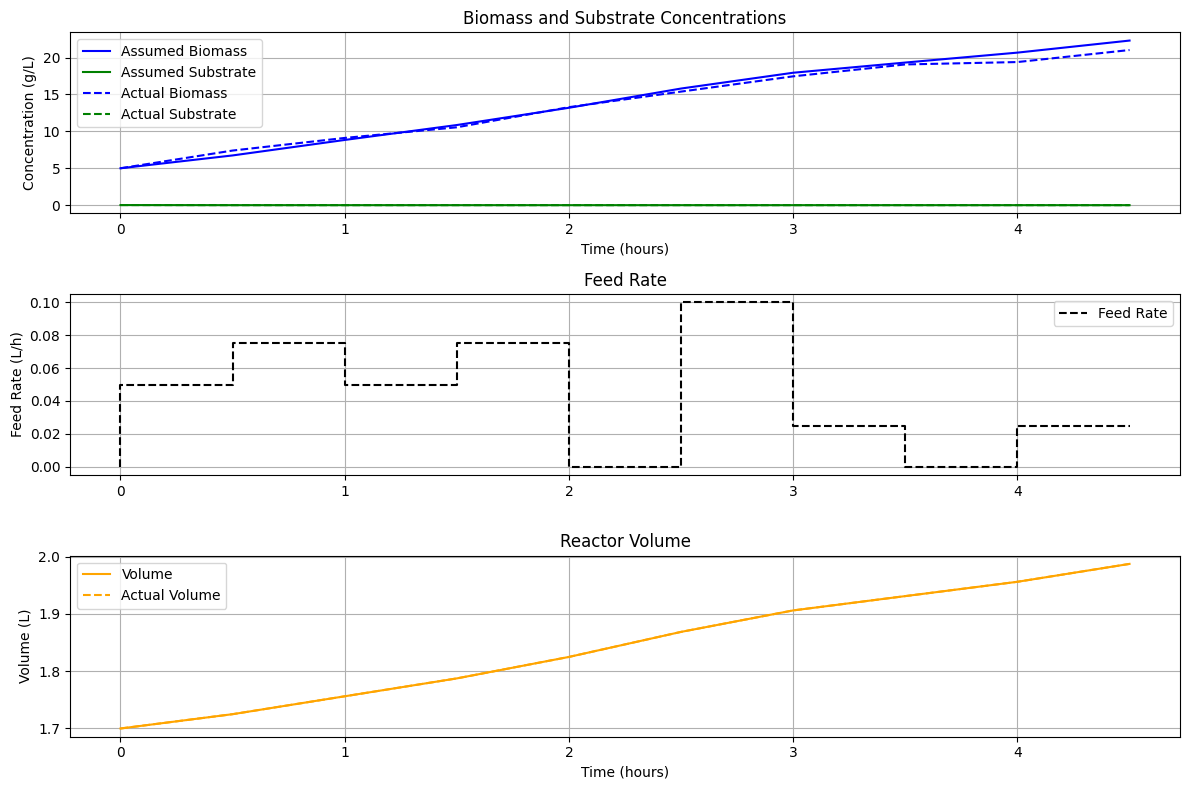

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)

# Number of data points
NUM_SAMPLES = 1000

# Kinetic parameters
MU_MAX = 0.86980       # 1/h
K_S    = 0.000123762       # g/l
Y_XS   = 0.4357       # g/g
Y_PX   = 0.2         # g/g
S_F    = 1.43 * 200  # g/l
K_I    = 54         # g/l

# Initial conditions
X_0 = 5
S_0 = 0.013
V_0 = 1.7

# ODE solver parameters
ODE_SOLVER = 'RK45'

# Time parameters
T_START = 0
T_END = 5
TIME_RANGE = int(T_END - T_START) # Absolute time 
dt = 0.5

# Feed rate (random function)
def Fs(t):
    return np.random.choice([0, 0.1, 0.05, 0.025, 0.075])

# Actual system model with cell death and substrate inhibition
def actual_system(t, y, F_func: callable, k_d: float = 0.009):
    X, S, V = y
    F = F_func(t)
    mu = MU_MAX * S / (K_S + S + S**2 / K_I)  # Monod equation
    dX_dt = mu * X - (F / V) * X - k_d * X
    dS_dt = -(1 / Y_XS) * mu * X + (F / V) * (S_F - S)
    dV_dt = F
    return [dX_dt, dS_dt, dV_dt]

# Assumed system model 
def dynamic_system(t, y, F_func: callable):
    ''' Real system model with cell death and substrate inhibition '''
    X, S, V = y
    F = F_func(t)
    mu = MU_MAX * S / (K_S + S)  # Monod equation
    dX_dt = mu * X - (F / V) * X 
    dS_dt = -(1 / Y_XS) * mu * X + (F / V) * (S_F - S) 
    dV_dt = F
    return [dX_dt, dS_dt, dV_dt]


def simulate(F: callable, plot: bool=True, real: bool=True) -> np.ndarray:
    """ Simulate bioreactor system using ODEs 
    - F: feed rate (assumed constant)
    - real: if True, simulate also the real system model; otherwise, only plant model
    """
    t_points = np.arange(T_START, T_END, dt)
    F_func = interp1d(t_points, [F(t) for t in t_points], kind="linear", fill_value="extrapolate")
    
    sol = solve_ivp(dynamic_system, t_span=(T_START, T_END), y0=[X_0, S_0, V_0], args=(F_func,), t_eval=np.arange(T_START, T_END, dt), method='LSODA', rtol=1e-6, atol=1e-12)

    if real:
        # Simulate the real system
        sol_real = solve_ivp(actual_system, t_span=(T_START, T_END), y0=[X_0, S_0, V_0], args=(F_func,), t_eval=np.arange(T_START, T_END, dt), method='LSODA', rtol=1e-6, atol=1e-12)
        # Add noise to the real system
        sol_real.y[0][1:] += np.random.normal(0, sol_real.y[0].max() * 0.02, size=sol_real.y[0][1:].shape)
        sol_real.y[1][1:] += np.random.normal(0, sol_real.y[1].max() * 0.02, size=sol_real.y[1][1:].shape)
    
    print(f'Maximum biomass concentration: {np.max(sol.y[0]):.2f} g/l at time {sol.t[np.argmax(sol.y[0])]:.2f} hours')
    if plot:
        plt.figure(figsize=(12, 8))
        
        # Plot Biomass and Substrate
        ax1 = plt.subplot(3, 1, 1)
        ax1.plot(sol.t, sol.y[0], label='Assumed Biomass', color='blue')
        ax1.plot(sol.t, sol.y[1], label='Assumed Substrate', color='green')
        if real:
            ax1.plot(sol_real.t, sol_real.y[0], label='Actual Biomass', color='blue', linestyle='--')
            ax1.plot(sol_real.t, sol_real.y[1], label='Actual Substrate', color='green', linestyle='--')
        ax1.set_title('Biomass and Substrate Concentrations')
        ax1.set_xlabel('Time (hours)')
        ax1.set_ylabel('Concentration (g/L)')
        ax1.legend(loc='upper left')
        ax1.grid()

        # Plot Feed Rate
        ax2 = plt.subplot(3, 1, 2)
        ax2.step(sol.t, [F(t) for t in sol.t], label='Feed Rate', color='black', linestyle='--')
        ax2.set_ylabel('Feed Rate (L/h)')
        ax2.set_title('Feed Rate')
        ax2.legend(loc='upper right')
        ax2.grid()

        # Plot Volume
        ax3 = plt.subplot(3, 1, 3)
        ax3.plot(sol.t, sol.y[2], label='Volume', color='orange')
        if real:
            ax3.plot(sol_real.t, sol_real.y[2], label='Actual Volume', color='orange', linestyle='--')
        ax3.set_title('Reactor Volume')
        ax3.set_xlabel('Time (hours)')
        ax3.set_ylabel('Volume (L)')
        ax3.legend()
        ax3.grid()

        plt.tight_layout()
        plt.show()
        
    return sol

sol = simulate(Fs)